In [1]:
import cpr_gym
import itertools
import git
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import psutil
import seaborn as sns
import time
import warnings
from pandarallel import pandarallel
from stable_baselines3 import PPO
from tqdm.notebook import tqdm

tqdm.pandas()
pandarallel.initialize(progress_bar=True, nb_workers=psutil.cpu_count(logical=True))

print("cpr_lib_version: " + cpr_gym.engine.cpr_lib_version)

repo = git.Repo(".", search_parent_directories=True)
repo.working_tree_dir
os.chdir(repo.working_tree_dir)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
cpr_lib_version: github_ci-ubuntu-20.04-v0.5.4


In [2]:
protocols = dict(
    nakamoto=(cpr_gym.protocols.nakamoto, []),
    tailstorm=(cpr_gym.protocols.tailstorm, ["k", "reward", "subblock_selection"]),
    tailstormll=(cpr_gym.protocols.tailstormll, ["k", "reward", "subblock_selection"]),
)
episode_len = 2048
n_episodes = 25
alpha = np.arange(0.1, 0.501, 0.025)


def env_fn(x, episode_len=episode_len):
    proto, proto_args = protocols[x.protocol]
    proto_args = {k: x[k] for k in proto_args}
    alpha = x.alpha if "alpha" in x.keys() else 0
    defenders = np.ceil((1 - alpha) / (1 - x.gamma))
    env = gym.make(
        "cpr_gym:core-v0",
        proto=proto(**proto_args),
        gamma=x.gamma,
        defenders=defenders,
        alpha=alpha,
        max_time=episode_len,
        max_steps=episode_len * 10000,
    )
    return env

# Data generation

## Find trained models

In [3]:
def models():
    for m in pathlib.Path("data/models").glob("*-sb3-ppo-*.zip"):
        x = m.stem.split("-sb3-ppo-")
        y = x[1].split("-")
        protocol = y[0]
        if protocol == "nakamoto":
            yield dict(
                policy=x[0],
                protocol=y[0],
                k=1,
                reward="btc",
                subblock_selection="n/a",
                gamma=int(y[1].removeprefix("gamma")) / 100,
                path=m,
            )
        elif protocol == "tailstorm" or protocol == "tailstormll":
            yield dict(
                policy=x[0],
                protocol=y[0],
                k=int(y[1]),
                reward=y[2],
                subblock_selection=y[3],
                gamma=int(y[4].removeprefix("gamma")) / 100,
                path=m,
            )
        else:
            raise Exception(f"unsupported protocol: {protocol}")


models = pd.DataFrame(models()).assign(kind="trained", reused=False)

# reuse some trained models for other settings
models = pd.concat(
    [
        models,
        # models.query(
        #    'protocol == "tailstorm" and subblock_selection == "heuristic"'
        # ).assign(reused=True, subblock_selection="optimal"),
    ],
    ignore_index=True,
)

models = pd.concat(
    [
        models,
        models.query('protocol == "tailstorm" and reward == "constant"').assign(
            reused=True, reward="discount"
        ),
        models.query('protocol == "tailstorm" and reward == "discount"').assign(
            reused=True, reward="constant"
        ),
    ]
)

models = pd.concat(
    [
        models,
        models.query("gamma == 0.5").assign(
            reused=True,
            gamma=0,
        ),
        models.query("gamma == 0.5").assign(
            reused=True,
            gamma=0.9,
        ),
    ],
    ignore_index=True,
)

models

,policy,protocol,k,reward,subblock_selection,gamma,path,kind,reused
0,wandb-380,nakamoto,1,btc,n/a,0.0,data/models/wandb-380-sb3-ppo-nakamoto-gamma00...,trained,False
1,wandb-381,tailstorm,8,constant,heuristic,0.5,data/models/wandb-381-sb3-ppo-tailstorm-8-cons...,trained,False
2,wandb-352,nakamoto,1,btc,n/a,0.5,data/models/wandb-352-sb3-ppo-nakamoto-gamma50...,trained,False
3,wandb-361,nakamoto,1,btc,n/a,0.5,data/models/wandb-361-sb3-ppo-nakamoto-gamma50...,trained,False
4,wandb-376,tailstorm,8,discount,heuristic,0.5,data/models/wandb-376-sb3-ppo-tailstorm-8-disc...,trained,False
5,wandb-337,tailstorm,8,constant,heuristic,0.5,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,trained,False
6,wandb-381,tailstorm,8,discount,heuristic,0.5,data/models/wandb-381-sb3-ppo-tailstorm-8-cons...,trained,True
7,wandb-337,tailstorm,8,discount,heuristic,0.5,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,trained,True
8,wandb-376,tailstorm,8,constant,heuristic,0.5,data/models/wandb-376-sb3-ppo-tailstorm-8-disc...,trained,True
9,wandb-381,tailstorm,8,constant,heuristic,0.0,data/models/wandb-381-sb3-ppo-tailstorm-8-cons...,trained,True


## Find hard-coded policies

In [4]:
scenarios = models[
    ["protocol", "k", "reward", "subblock_selection", "gamma"]
].drop_duplicates()


def policies():
    for _idx, x in scenarios.iterrows():
        env = env_fn(x)
        for p in env.policies():
            x = x.copy()
            x["policy"] = p
            yield x


policies = (
    pd.DataFrame(policies())
    .reset_index(drop=True)
    .assign(kind="hard-coded", path="n/a", reused=False)
)

policies.drop(columns=["gamma"]).drop_duplicates()

,protocol,k,reward,subblock_selection,policy,kind,path,reused
0,nakamoto,1,btc,n/a,sapirshtein-2016-sm1,hard-coded,n/a,False
1,nakamoto,1,btc,n/a,eyal-sirer-2014,hard-coded,n/a,False
2,nakamoto,1,btc,n/a,simple,hard-coded,n/a,False
3,nakamoto,1,btc,n/a,honest,hard-coded,n/a,False
4,tailstorm,8,constant,heuristic,override-catchup,hard-coded,n/a,False
5,tailstorm,8,constant,heuristic,override-block,hard-coded,n/a,False
6,tailstorm,8,constant,heuristic,release-block,hard-coded,n/a,False
7,tailstorm,8,constant,heuristic,honest,hard-coded,n/a,False
12,tailstorm,8,discount,heuristic,override-catchup,hard-coded,n/a,False
13,tailstorm,8,discount,heuristic,override-block,hard-coded,n/a,False


## Run simulations

In [5]:
models_and_policies = pd.concat([models, policies], ignore_index=True)


def episodes():
    for i in range(0, n_episodes):
        for a in alpha:
            yield models_and_policies.assign(episode=i, alpha=a)


episodes = pd.concat(episodes(), ignore_index=True)

loaded = {}


def load(path):
    if path in loaded.keys():
        return loaded[path]
    else:
        m = PPO.load(path)
        loaded[path] = m
        return m


def observe_episode(info):
    return pd.Series(
        {
            k: info[k]
            for k in [
                "episode_reward_attacker",
                "episode_chain_time",
                "episode_progress",
            ]
        }
    )


def measure_trained(x, env_fn=env_fn, **kwargs):
    env = env_fn(x)
    model = load(x.path)
    obs = env.reset()
    done = False
    observed_alpha = kwargs["pretend_alpha"] if "pretend_alpha" in kwargs else x.alpha
    while not done:
        extobs = np.append(obs, [observed_alpha])
        action, _ = model.predict(extobs, deterministic=True)
        obs, _reward, done, info = env.step(action)
    return observe_episode(info)


def measure_hardcoded(x, env_fn=env_fn, **kwargs):
    env = env_fn(x)
    obs = env.reset()
    done = False
    while not done:
        action = env.policy(obs, x.policy)
        obs, reward, done, info = env.step(action)
    return observe_episode(info)


def measure(x, **kwargs):
    if x.kind == "trained":
        return measure_trained(x, **kwargs)
    if x.kind == "hard-coded":
        return measure_hardcoded(x, **kwargs)
    assert False


# run simulations or restore from cached file

digest = hex(
    abs(hash(tuple([episode_len] + list(pd.util.hash_pandas_object(episodes)))))
)
fname = f"data/rl-eval-episodes-{digest}.pkl"
try:
    episodes = pd.read_pickle(fname)
    print(f"restore from {fname}")
except FileNotFoundError:
    # results = d.progress_apply(
    results = episodes.parallel_apply(
        measure,
        axis=1,
    )
    episodes = pd.concat([episodes, results], axis=1)
    episodes.to_pickle(fname)
    episodes.columns

restore from data/rl-eval-episodes-0x2e15ad5b86af835e.pkl


# Best hard-coded policies

In [6]:
scenario = ["protocol", "k", "reward", "subblock_selection", "gamma", "alpha"]
policy = ["policy", "kind", "reused", "path"]
d = episodes.query("kind=='hard-coded'")
mhc_means = (
    d.assign(episode_reward=d.episode_reward_attacker / d.episode_progress)
    .groupby(scenario + policy, as_index=False)
    .episode_reward.mean()
)
mhc_policies = (
    mhc_means.loc[mhc_means.groupby(scenario).episode_reward.idxmax()]
    .drop(columns=["episode_reward"])
    .reset_index(drop=True)
)
display(mhc_policies)

mhc_episodes = mhc_policies.join(
    d.set_index(scenario + policy), on=scenario + policy
).assign(policy="max-hard-coded", kind="hard-coded")
display(mhc_episodes.columns)

,protocol,k,reward,subblock_selection,gamma,alpha,policy,kind,reused,path
0,nakamoto,1,btc,n/a,0.0,0.100,honest,hard-coded,False,n/a
1,nakamoto,1,btc,n/a,0.0,0.125,honest,hard-coded,False,n/a
2,nakamoto,1,btc,n/a,0.0,0.150,honest,hard-coded,False,n/a
3,nakamoto,1,btc,n/a,0.0,0.175,honest,hard-coded,False,n/a
4,nakamoto,1,btc,n/a,0.0,0.200,honest,hard-coded,False,n/a
...,...,...,...,...,...,...,...,...,...,...
148,tailstorm,8,discount,heuristic,0.9,0.400,override-catchup,hard-coded,False,n/a
149,tailstorm,8,discount,heuristic,0.9,0.425,override-catchup,hard-coded,False,n/a
150,tailstorm,8,discount,heuristic,0.9,0.450,override-catchup,hard-coded,False,n/a
151,tailstorm,8,discount,heuristic,0.9,0.475,override-catchup,hard-coded,False,n/a


Index(['protocol', 'k', 'reward', 'subblock_selection', 'gamma', 'alpha',
       'policy', 'kind', 'reused', 'path', 'episode',
       'episode_reward_attacker', 'episode_chain_time', 'episode_progress'],
      dtype='object')

# Compare RL against best hard-coded

## Reward per progress (in DAA equilibrium)

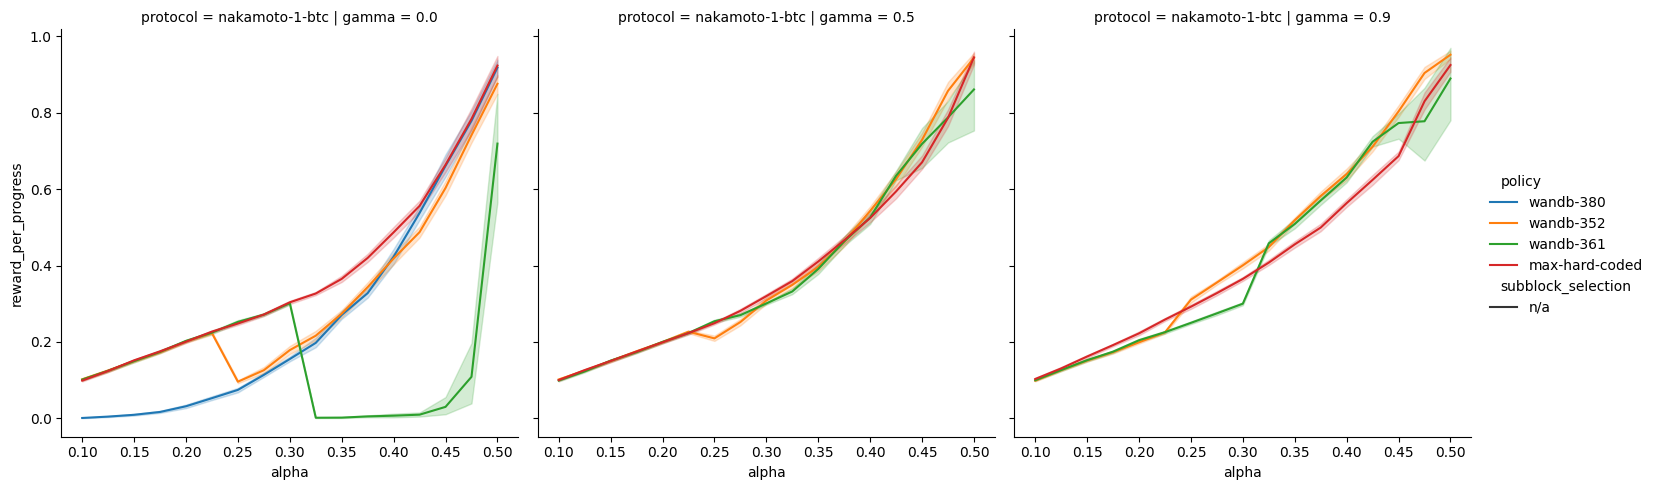

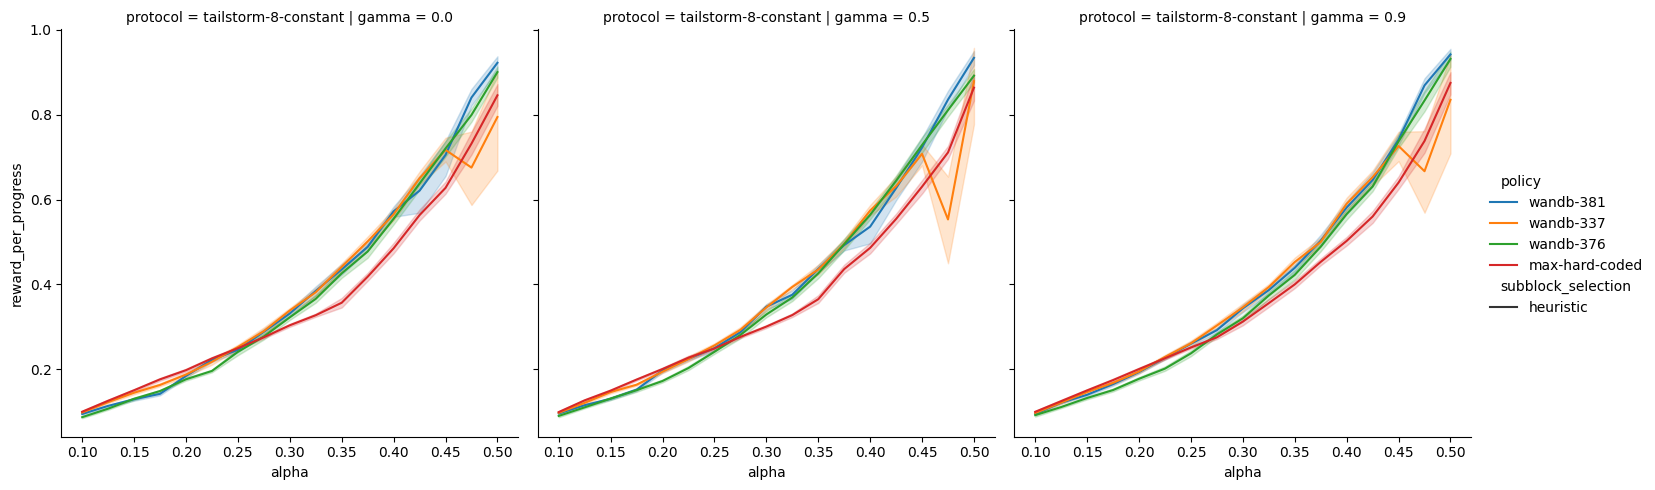

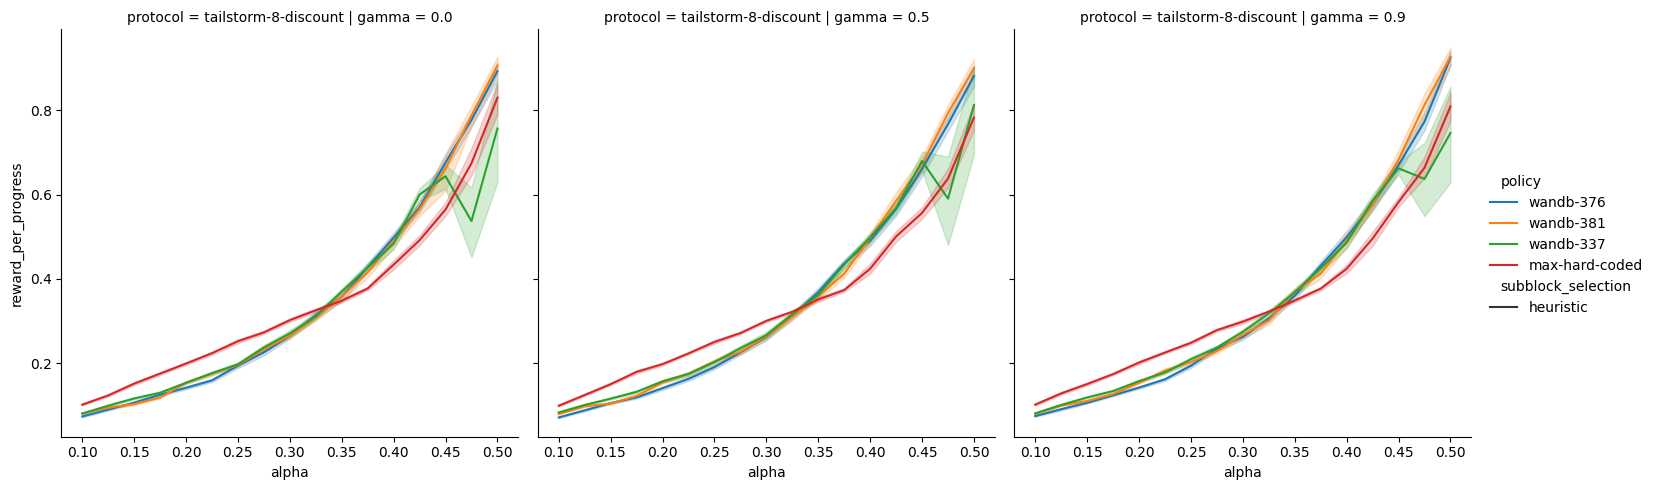

In [7]:
d = pd.concat([episodes.query('kind=="trained"'), mhc_episodes])
d = d.assign(
    protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
    reward_per_progress=d.episode_reward_attacker / d.episode_progress,
    reward_pkel=d.episode_reward_attacker / d.episode_progress / d.alpha,
    reward_bglick=d.episode_reward_attacker / d.episode_progress - d.alpha,
    orphan_rate=d.episode_chain_time / d.episode_progress,
)
for protocol in d.protocol.drop_duplicates():
    sns.relplot(
        data=d.query(f"protocol == '{protocol}'"),
        kind="line",
        x="alpha",
        y="reward_per_progress",
        hue="policy",
        style="subblock_selection",
        row="protocol",
        col="gamma",
    )
    plt.show()

## Reward, Patrik-style

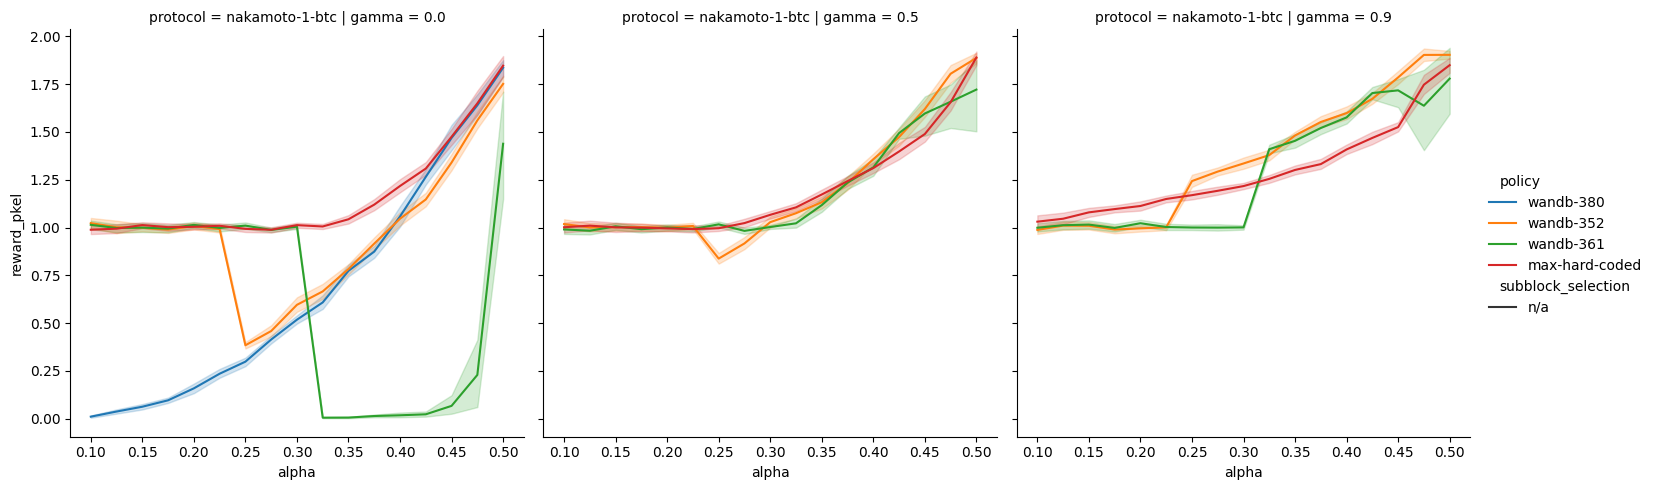

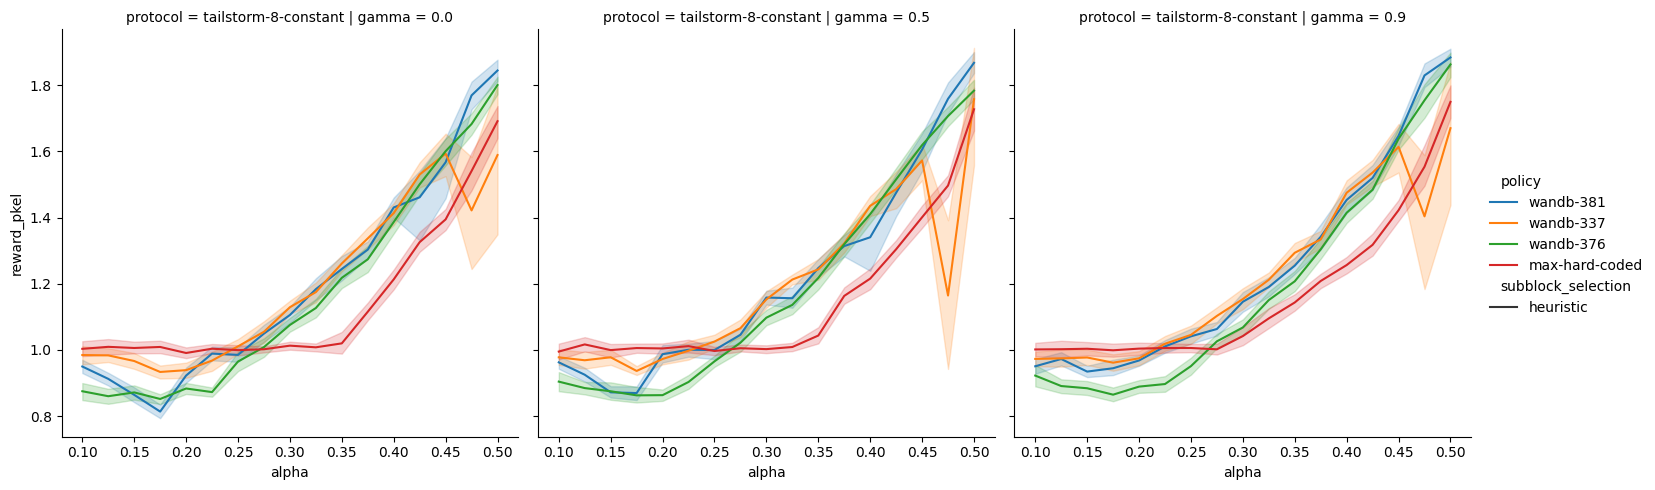

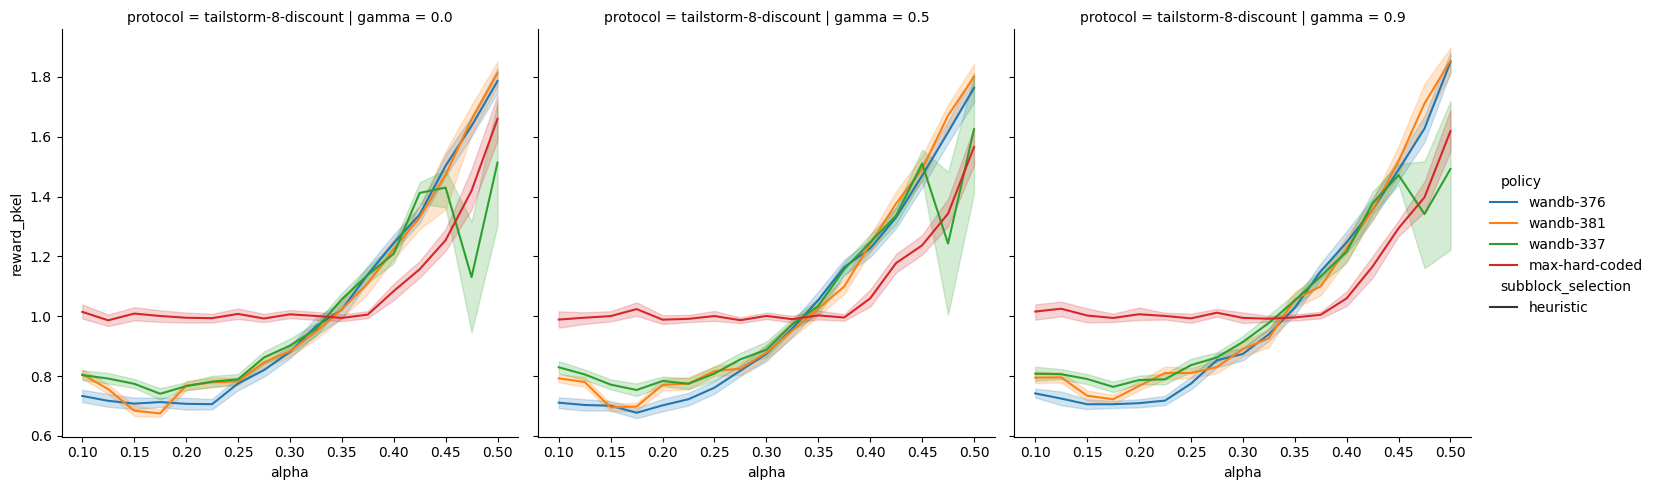

In [8]:
for protocol in d.protocol.drop_duplicates():
    sns.relplot(
        data=d.query(f"protocol == '{protocol}'"),
        kind="line",
        x="alpha",
        y="reward_pkel",
        hue="policy",
        style="subblock_selection",
        row="protocol",
        col="gamma",
    )
    plt.show()

## Reward, Ben-style

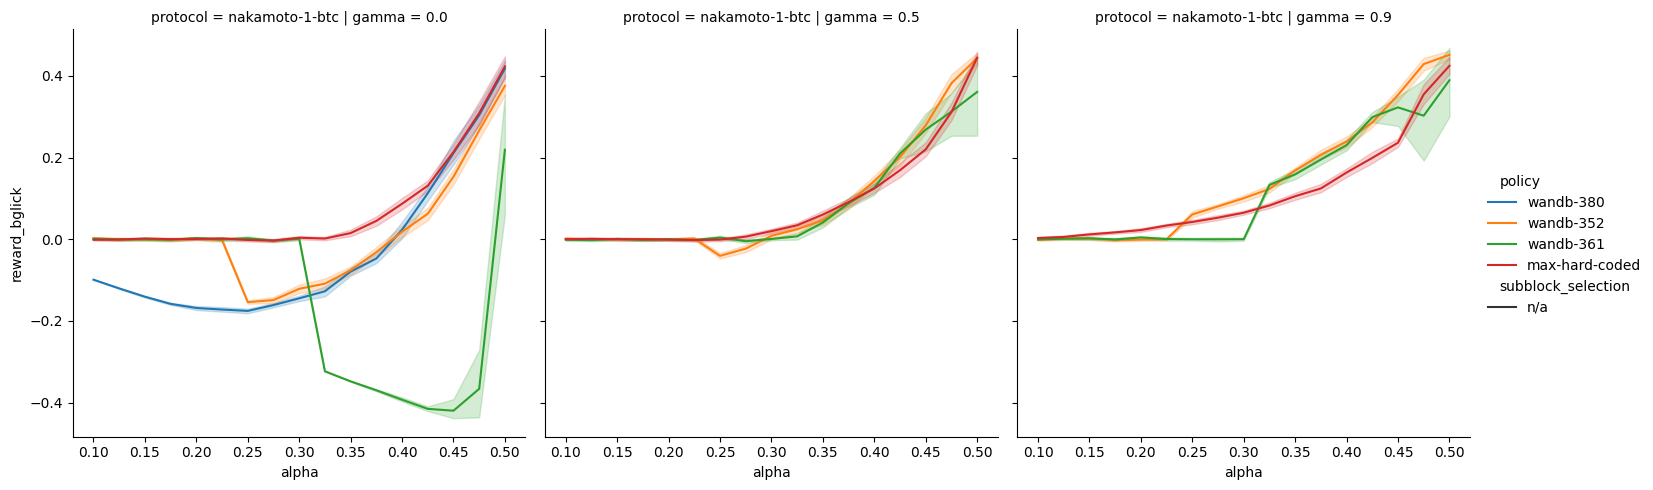

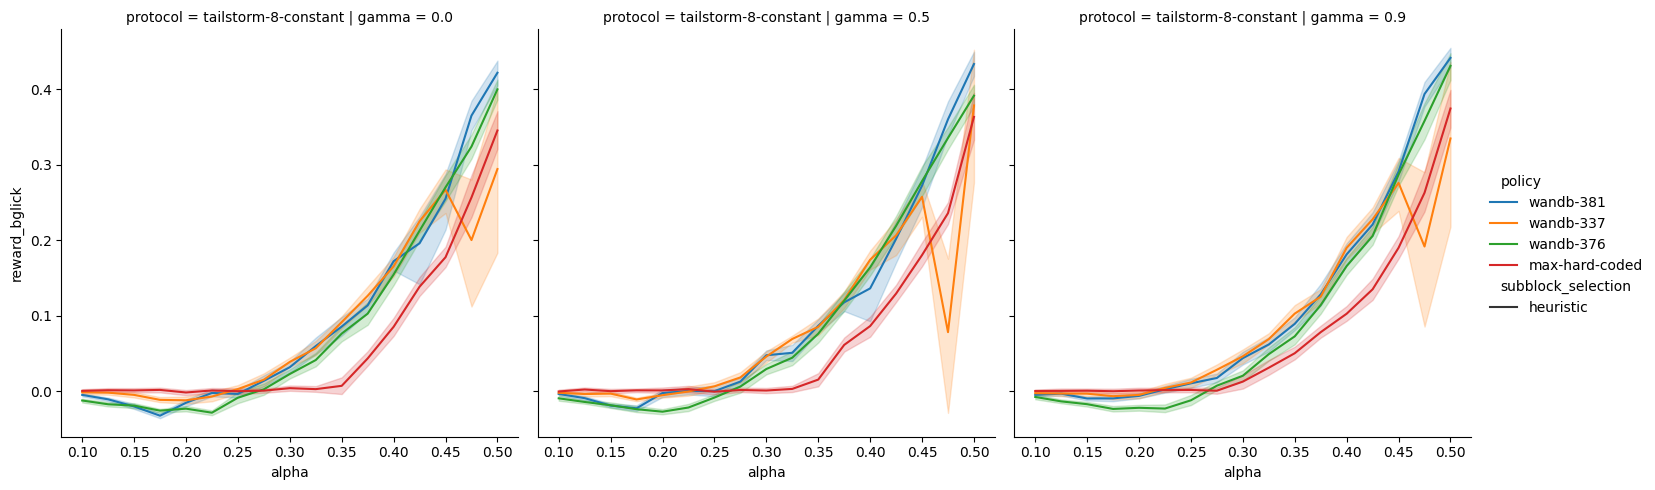

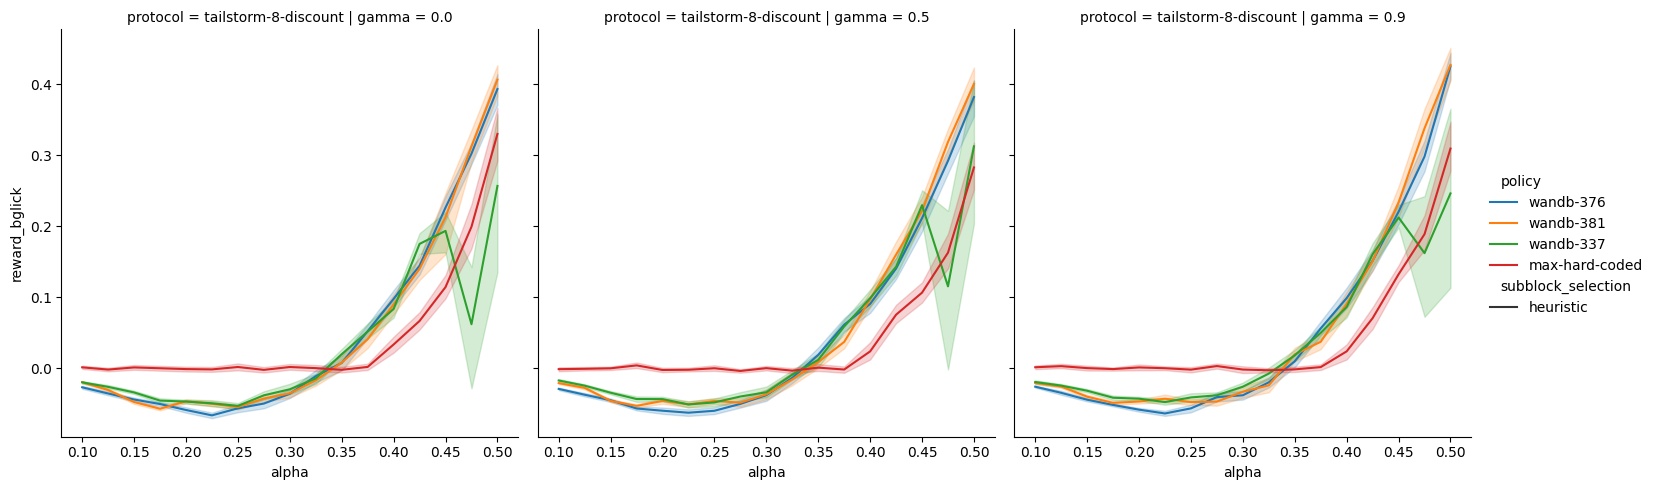

In [9]:
for protocol in d.protocol.drop_duplicates():
    sns.relplot(
        data=d.query(f"protocol == '{protocol}'"),
        kind="line",
        x="alpha",
        y="reward_bglick",
        hue="policy",
        style="subblock_selection",
        row="protocol",
        col="gamma",
    )
    plt.show()

## Orphans

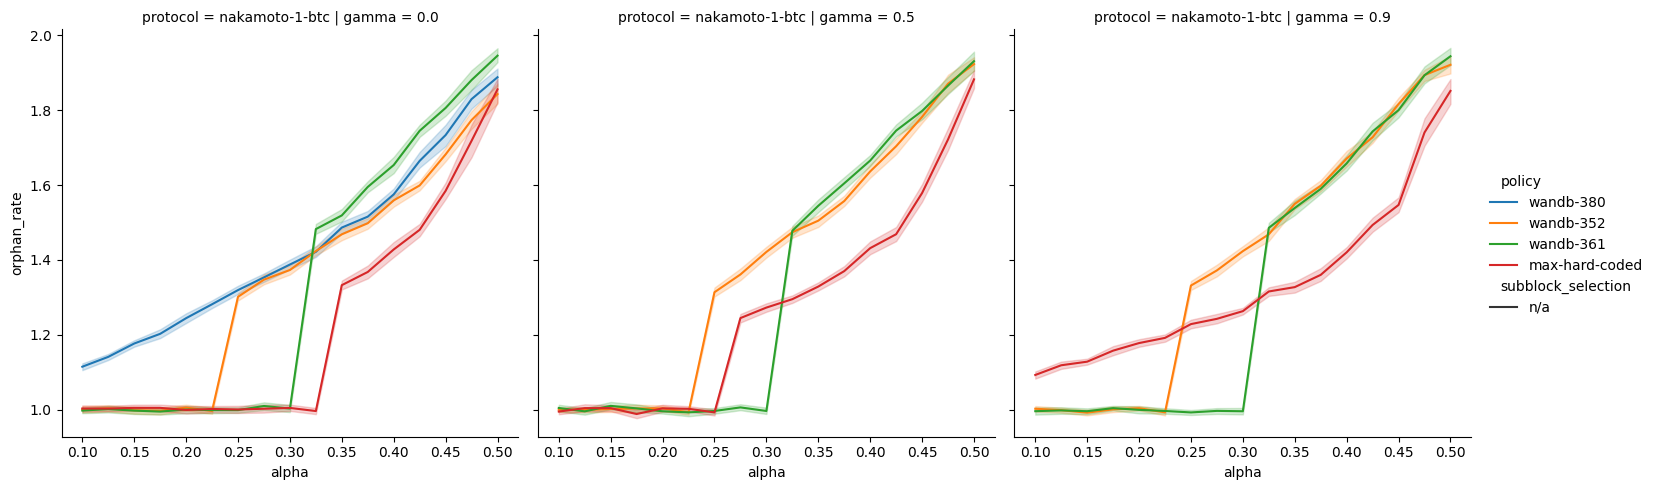

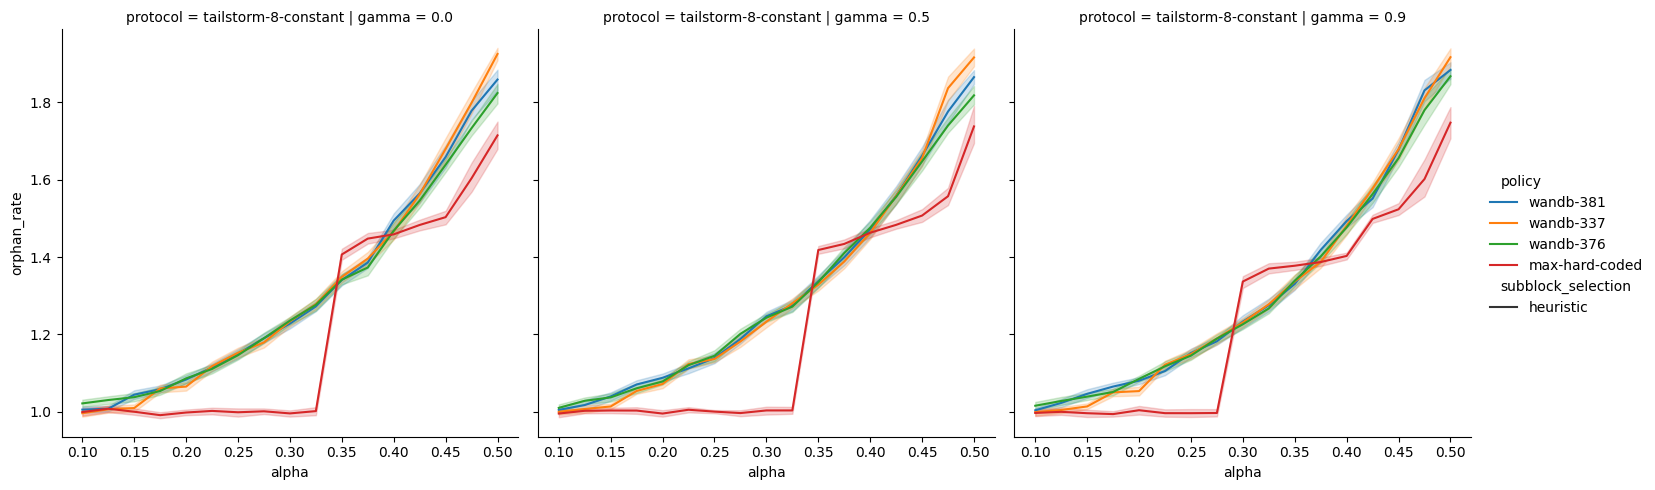

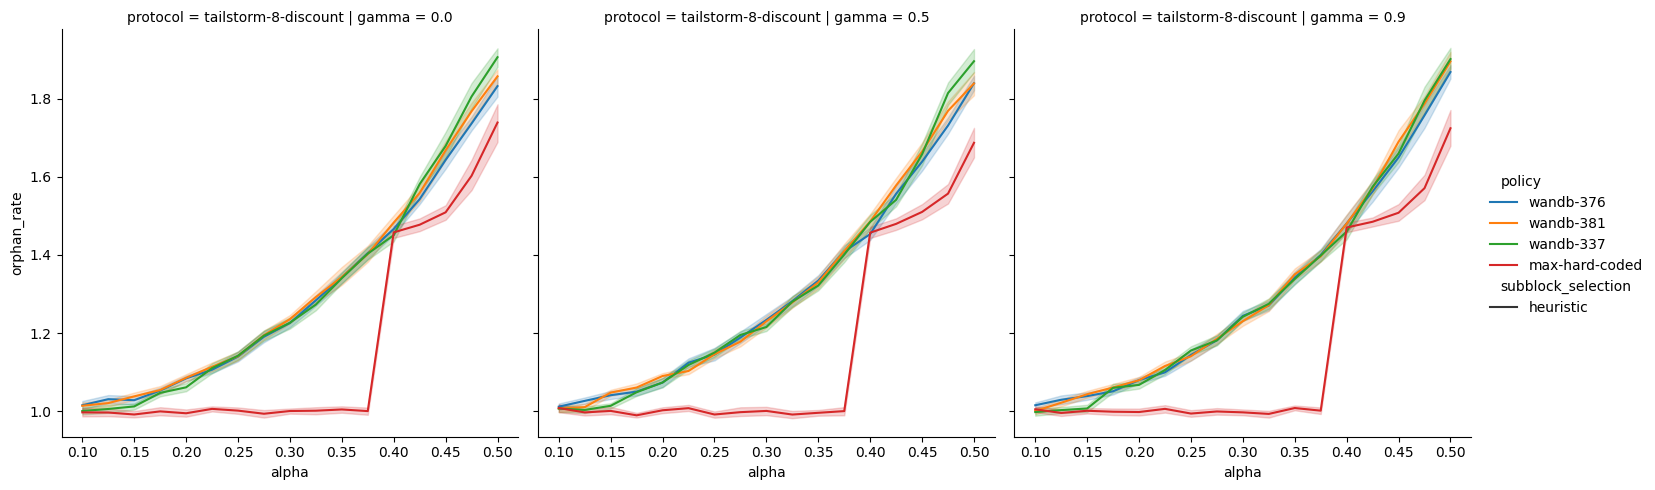

In [10]:
for protocol in d.protocol.drop_duplicates():
    sns.relplot(
        data=d.query(f"protocol == '{protocol}'"),
        kind="line",
        x="alpha",
        y="orphan_rate",
        hue="policy",
        style="subblock_selection",
        row="protocol",
        col="gamma",
    )
    plt.show()

# Best strategies; RL & hard-coded

In [11]:
scenario = ["protocol", "k", "reward", "subblock_selection", "gamma", "alpha"]
policy = ["policy", "kind", "reused", "path"]
d = episodes
opt_means = (
    d.assign(episode_reward=d.episode_reward_attacker / d.episode_progress)
    .groupby(scenario + policy, as_index=False)
    .episode_reward.mean()
)
opt_policies = (
    opt_means.loc[opt_means.groupby(scenario).episode_reward.idxmax()]
    .drop(columns=["episode_reward"])
    .reset_index(drop=True)
)
display(opt_policies)

opt_episodes = opt_policies.join(d.set_index(scenario + policy), on=scenario + policy)
display(opt_episodes.columns)

,protocol,k,reward,subblock_selection,gamma,alpha,policy,kind,reused,path
0,nakamoto,1,btc,n/a,0.0,0.100,wandb-352,trained,True,data/models/wandb-352-sb3-ppo-nakamoto-gamma50...
1,nakamoto,1,btc,n/a,0.0,0.125,wandb-352,trained,True,data/models/wandb-352-sb3-ppo-nakamoto-gamma50...
2,nakamoto,1,btc,n/a,0.0,0.150,honest,hard-coded,False,n/a
3,nakamoto,1,btc,n/a,0.0,0.175,honest,hard-coded,False,n/a
4,nakamoto,1,btc,n/a,0.0,0.200,wandb-361,trained,True,data/models/wandb-361-sb3-ppo-nakamoto-gamma50...
...,...,...,...,...,...,...,...,...,...,...
148,tailstorm,8,discount,heuristic,0.9,0.400,wandb-376,trained,True,data/models/wandb-376-sb3-ppo-tailstorm-8-disc...
149,tailstorm,8,discount,heuristic,0.9,0.425,wandb-337,trained,True,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...
150,tailstorm,8,discount,heuristic,0.9,0.450,wandb-381,trained,True,data/models/wandb-381-sb3-ppo-tailstorm-8-cons...
151,tailstorm,8,discount,heuristic,0.9,0.475,wandb-381,trained,True,data/models/wandb-381-sb3-ppo-tailstorm-8-cons...


Index(['protocol', 'k', 'reward', 'subblock_selection', 'gamma', 'alpha',
       'policy', 'kind', 'reused', 'path', 'episode',
       'episode_reward_attacker', 'episode_chain_time', 'episode_progress'],
      dtype='object')

## Reward per progress (in DAA equilibrium)

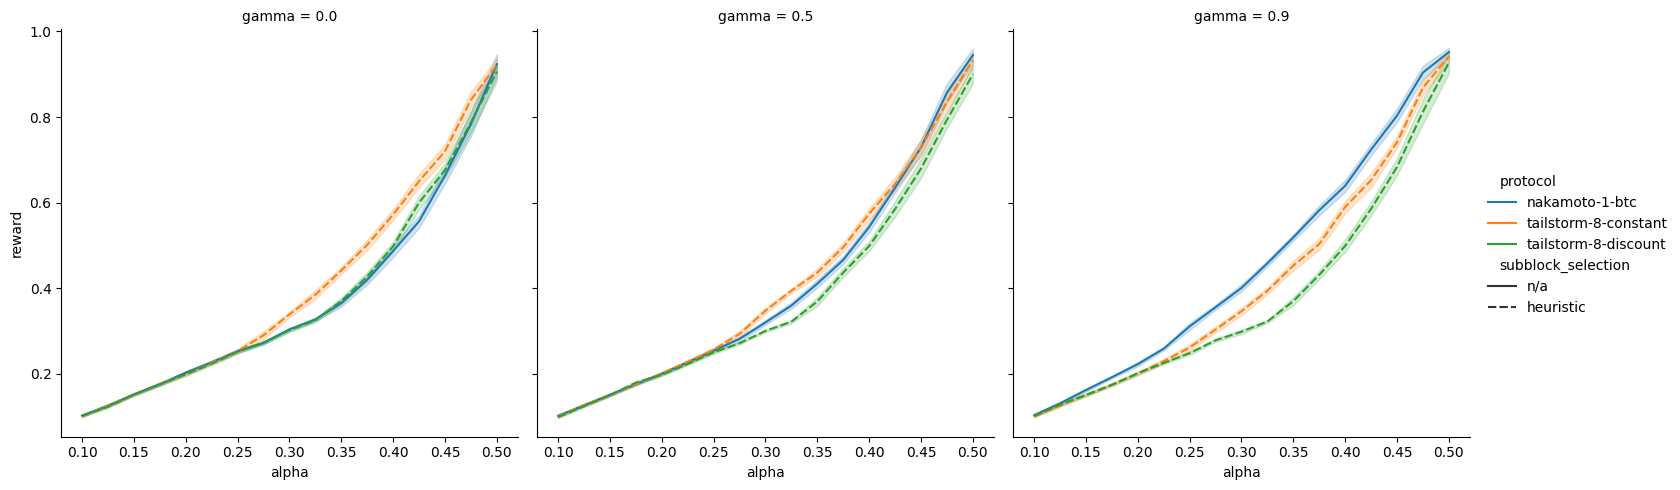

In [12]:
d = opt_episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress,
    ),
    kind="line",
    x="alpha",
    y="reward",
    style="subblock_selection",
    hue="protocol",
    col="gamma",
)

## Reward, Patrik-style

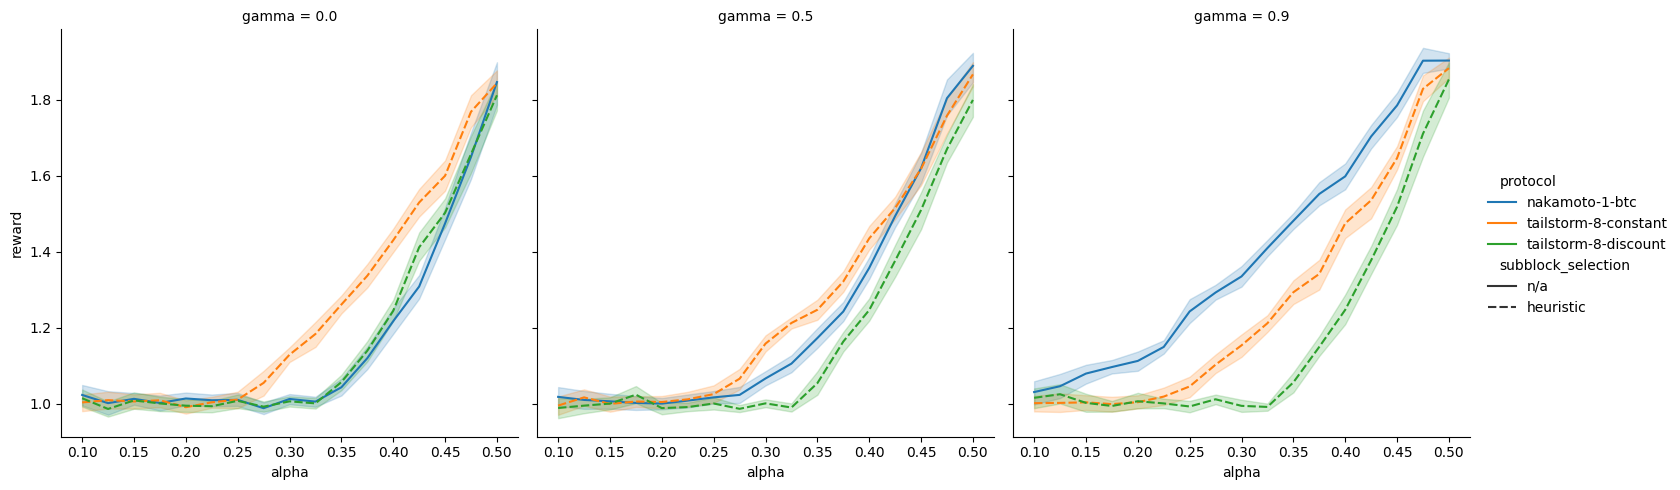

In [13]:
d = opt_episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress / d.alpha,
    ),
    kind="line",
    x="alpha",
    y="reward",
    style="subblock_selection",
    hue="protocol",
    col="gamma",
)

## Reward, Ben-style

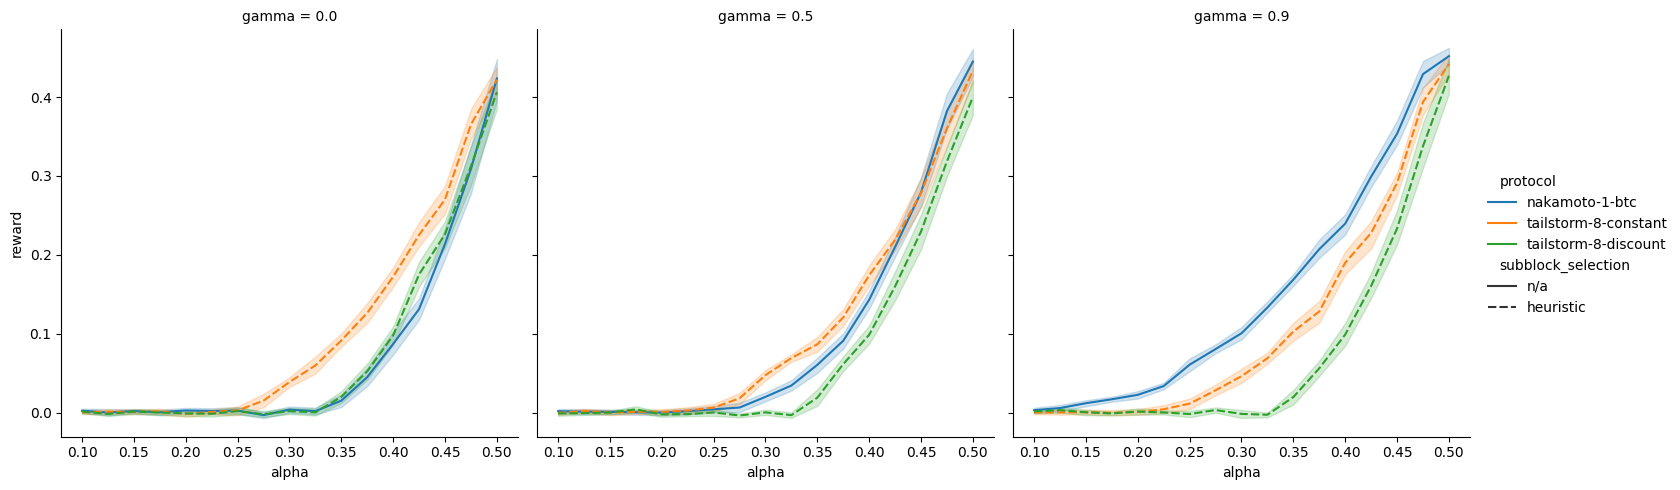

In [14]:
d = opt_episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        reward=d.episode_reward_attacker / d.episode_progress - d.alpha,
    ),
    kind="line",
    x="alpha",
    y="reward",
    style="subblock_selection",
    hue="protocol",
    col="gamma",
)

## Orphans

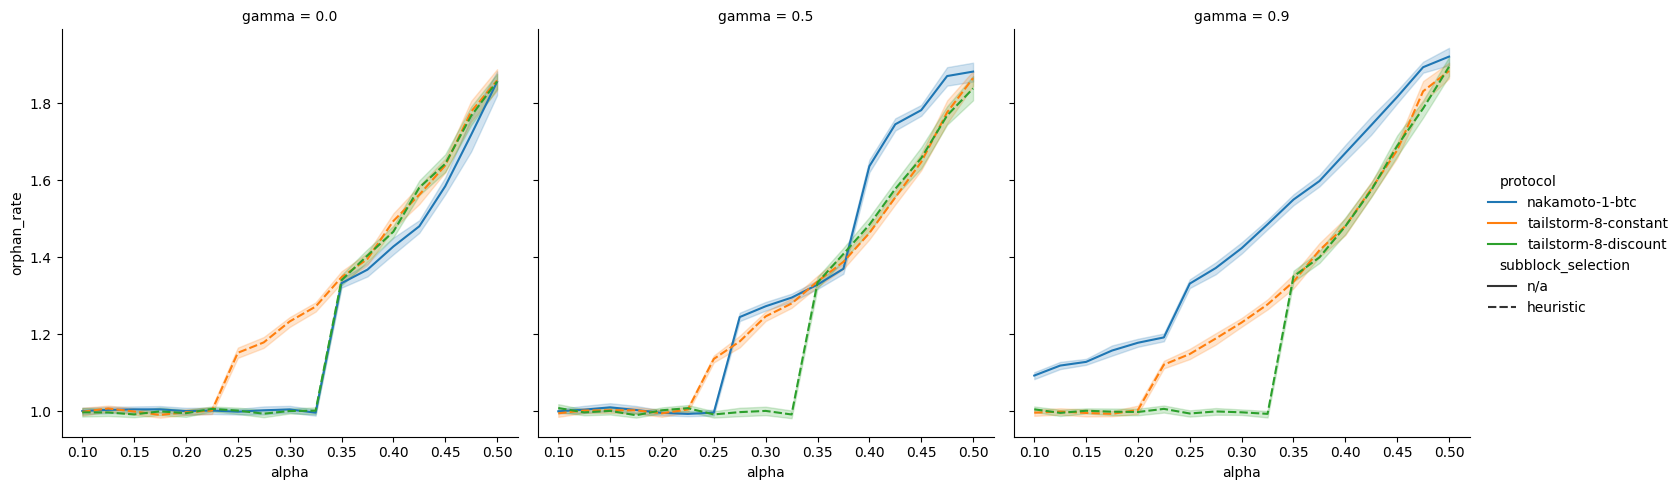

In [15]:
d = opt_episodes
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
        orphan_rate=d.episode_chain_time / d.episode_progress,
    ),
    kind="line",
    x="alpha",
    y="orphan_rate",
    style="subblock_selection",
    hue="protocol",
    col="gamma",
)

## Compress x-axis into single value

The resulting numbers are hard to interpret. Certainly, smaller implies less selfish-mining suspectibility, I'd say.

In [16]:
scenario = ["protocol", "k", "reward", "subblock_selection", "gamma"]
d = opt_episodes
d = (
    d.assign(
        raw=d.episode_reward_attacker / d.episode_progress,
        ben=d.episode_reward_attacker / d.episode_progress - d.alpha,
        patrik=d.episode_reward_attacker / d.episode_progress / d.alpha,
    )[scenario + ["raw", "ben", "patrik"]]
    .groupby(scenario)
    .mean()
)
d

raw       ben    patrik
protocol  k reward   subblock_selection gamma                              
nakamoto  1 btc      n/a                0.0    0.372881  0.072881  1.161250
                                        0.5    0.398953  0.098953  1.225894
                                        0.9    0.453990  0.153990  1.395642
tailstorm 8 constant heuristic          0.0    0.405426  0.105426  1.245536
                                        0.5    0.407072  0.107072  1.250644
                                        0.9    0.413888  0.113888  1.267642
            discount heuristic          0.0    0.375923  0.075923  1.166585
                                        0.5    0.375242  0.075242  1.164033
                                        0.9    0.378583  0.078583  1.173518

# Break-even point

Per protocol and gamma, we proceed as follows:
1. grid-search the lowest relative hash rate $\hat{\alpha}$, where best policy $P$ produces some orphans
2. $P$ should be the first profitable policy after the break-even point
3. derive policy $P_\hat{\alpha}$ from $P$ by hard-wiring $\hat{\alpha}$ in the observation
4. evaluate $P_\hat{\alpha}$ on full range of alphas
    1. set loss funtcion `loss(alpha) = abs(reward_attacker / episode_progress / alpha - 1)`
    2. minimize loss function with Bayesian optimization

In [17]:
scenario = ["protocol", "k", "reward", "subblock_selection", "gamma"]
policy = ["policy", "kind", "reused", "path"]
d = opt_episodes
d = d.assign(orphan_rate=d.episode_chain_time / d.episode_progress)
d = d.query("orphan_rate > 1.1")
be_means = d.groupby(scenario + policy + ["alpha"], as_index=False).alpha.mean()
display(be_means.policy.drop_duplicates().reset_index(drop=True))

be_policies = be_means.loc[be_means.groupby(scenario).alpha.idxmin()].reset_index(
    drop=True
)
display(be_policies)

0         eyal-sirer-2014
1    sapirshtein-2016-sm1
2               wandb-352
3               wandb-361
4                  simple
5               wandb-337
6               wandb-376
7               wandb-381
Name: policy, dtype: object

,protocol,k,reward,subblock_selection,gamma,policy,kind,reused,path,alpha
0,nakamoto,1,btc,n/a,0.0,sapirshtein-2016-sm1,hard-coded,False,n/a,0.350
1,nakamoto,1,btc,n/a,0.5,eyal-sirer-2014,hard-coded,False,n/a,0.275
2,nakamoto,1,btc,n/a,0.9,sapirshtein-2016-sm1,hard-coded,False,n/a,0.100
3,tailstorm,8,constant,heuristic,0.0,wandb-337,trained,True,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,0.250
4,tailstorm,8,constant,heuristic,0.5,wandb-337,trained,False,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,0.250
5,tailstorm,8,constant,heuristic,0.9,wandb-337,trained,True,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,0.225
6,tailstorm,8,discount,heuristic,0.0,wandb-337,trained,True,data/models/wandb-337-sb3-ppo-tailstorm-8-cons...,0.350
7,tailstorm,8,discount,heuristic,0.5,wandb-376,trained,False,data/models/wandb-376-sb3-ppo-tailstorm-8-disc...,0.350
8,tailstorm,8,discount,heuristic,0.9,wandb-381,trained,True,data/models/wandb-381-sb3-ppo-tailstorm-8-cons...,0.350


In [18]:
import io
import skopt
import skopt.plots
from skopt.space import Real
from skopt.utils import use_named_args

dimensions = [Real(name="alpha", low=min(alpha), high=max(alpha))]
n_calls = 42
be_episode_len = 8192


def objective_fn(policy):
    @use_named_args(dimensions=dimensions)
    def fn(alpha):
        x = policy.copy()
        x["alpha"] = alpha
        r = measure(
            x,
            env_fn=lambda x: env_fn(x, episode_len=be_episode_len),
            pretend_alpha=policy.alpha,
        )
        return np.abs(
            (r["episode_reward_attacker"] / r["episode_progress"] / alpha) - 1
        )

    return fn


def png_of_optimization(x, res, break_even):
    fig = plt.figure()
    ax = skopt.plots.plot_gaussian_process(res)
    ax.axvline(break_even, linestyle="solid", label="minimum/break-even")
    ax.axvline(res.x[0], linestyle="dashed", label="minimal observation")
    ax.legend(loc="best", numpoints=1)
    ax.set_xlabel("α")
    ax.set_ylabel("f(α)")
    ax.set_title(
        f"{x.protocol}({x.k}, {x.reward}, {x.subblock_selection})  γ={x.gamma}  {x.policy}"
    )
    buf = io.BytesIO()
    fig.savefig(buf, format="png")
    plt.close()
    buf.seek(0)
    return buf.getvalue()


def break_even_of_res(res):
    # res.x gives argmin of observation
    # the observations are stochastic, hence we cannot use res.x
    # revert last surrogate function instead
    # surrogate has support 0..1, thus transform alphas
    return res.x_iters[
        np.argmin(
            res.models[-1].predict(
                (res.x_iters - min(alpha)) / (max(alpha) - min(alpha))
            )
        )
    ][0]


def find_break_even(x):
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore", "The objective has been evaluated at this point before"
        )
        res = skopt.gp_minimize(objective_fn(x), dimensions, n_calls=n_calls)
        break_even = break_even_of_res(res)
        # optimizer result cannot be pickled
        # thus create plot here and save in dataframe
        png = png_of_optimization(x, res, break_even)
    return pd.Series(dict(break_even=break_even, break_even_png=png))


# d = be_policies.query("protocol == 'nakamoto'")
# d = be_policies.loc[[7]]
d = be_policies

digest = hex(
    abs(hash(tuple([be_episode_len, n_calls] + list(pd.util.hash_pandas_object(d)))))
)
fname = f"data/rl-eval-break-even-points-{digest}.pkl"
try:
    be_points = pd.read_pickle(fname)
    print(f"restore from {fname}")
except FileNotFoundError:
    # results = d.progress_apply(
    results = d.parallel_apply(
        find_break_even,
        axis=1,
    )
    be_points = pd.concat([d, results], axis=1)
    be_points.to_pickle(fname)

restore from data/rl-eval-break-even-points-0x149b054217259022.pkl


In [19]:
be_points.drop(columns=["path", "break_even_png"])

,protocol,k,reward,subblock_selection,gamma,policy,kind,reused,alpha,break_even
0,nakamoto,1,btc,n/a,0.0,sapirshtein-2016-sm1,hard-coded,False,0.350,0.330931
1,nakamoto,1,btc,n/a,0.5,eyal-sirer-2014,hard-coded,False,0.275,0.263238
2,nakamoto,1,btc,n/a,0.9,sapirshtein-2016-sm1,hard-coded,False,0.100,0.113780
3,tailstorm,8,constant,heuristic,0.0,wandb-337,trained,True,0.250,0.244628
4,tailstorm,8,constant,heuristic,0.5,wandb-337,trained,False,0.250,0.206796
5,tailstorm,8,constant,heuristic,0.9,wandb-337,trained,True,0.225,0.213118
6,tailstorm,8,discount,heuristic,0.0,wandb-337,trained,True,0.350,0.335289
7,tailstorm,8,discount,heuristic,0.5,wandb-376,trained,False,0.350,0.345226
8,tailstorm,8,discount,heuristic,0.9,wandb-381,trained,True,0.350,0.339910


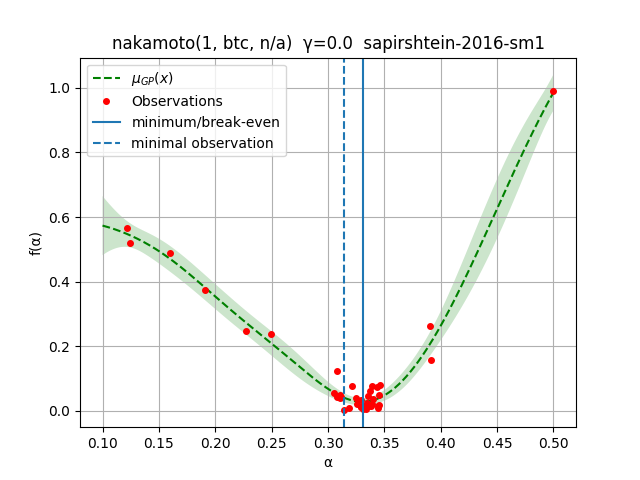

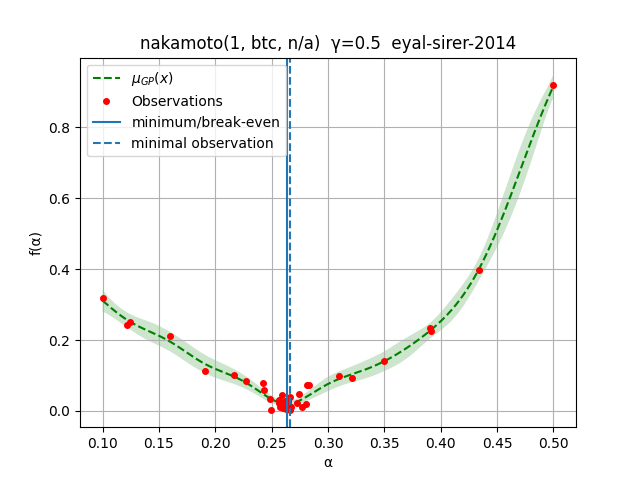

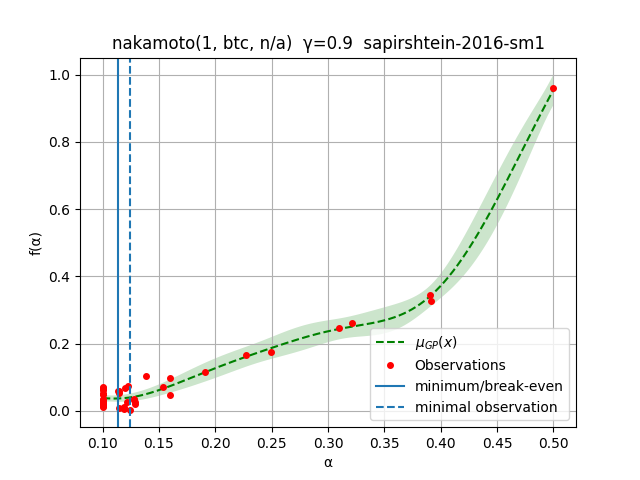

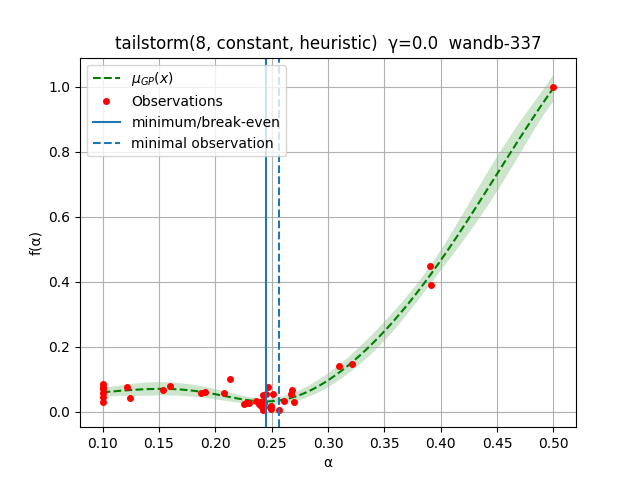

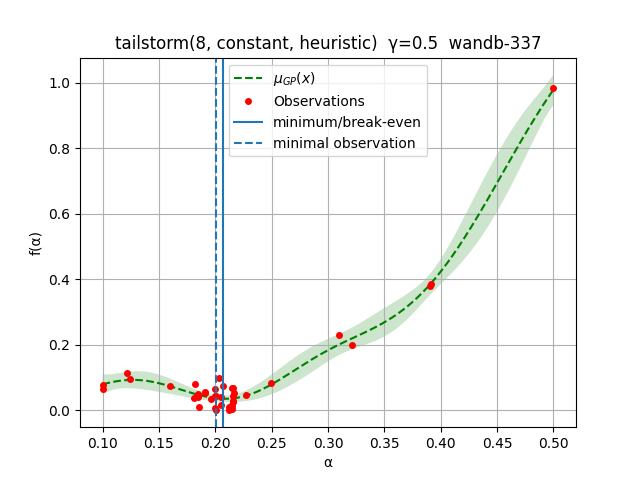

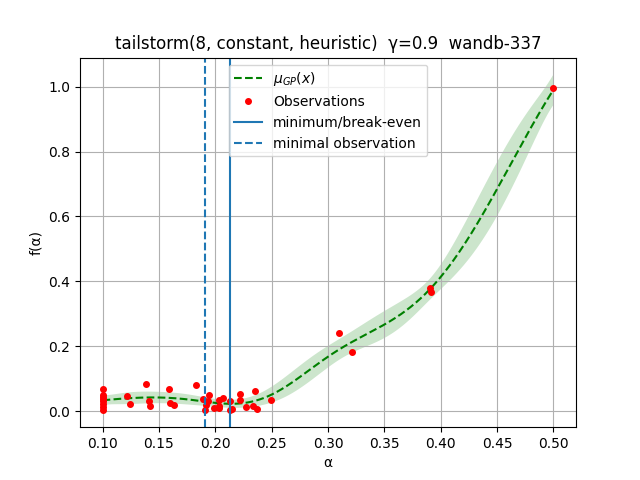

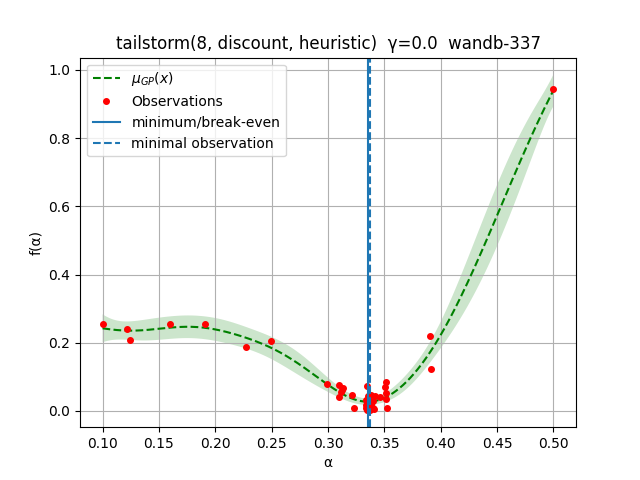

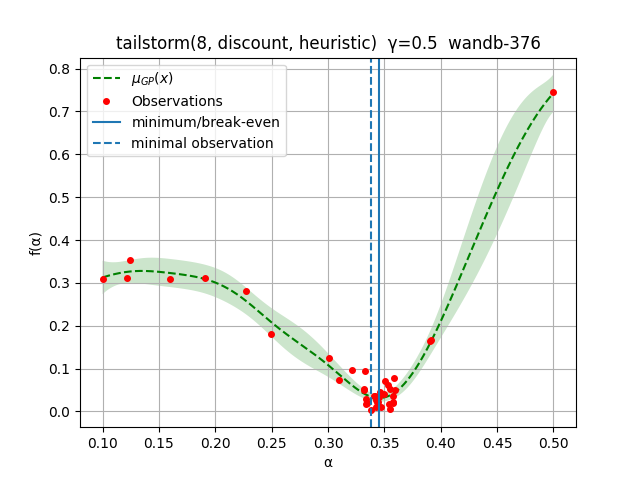

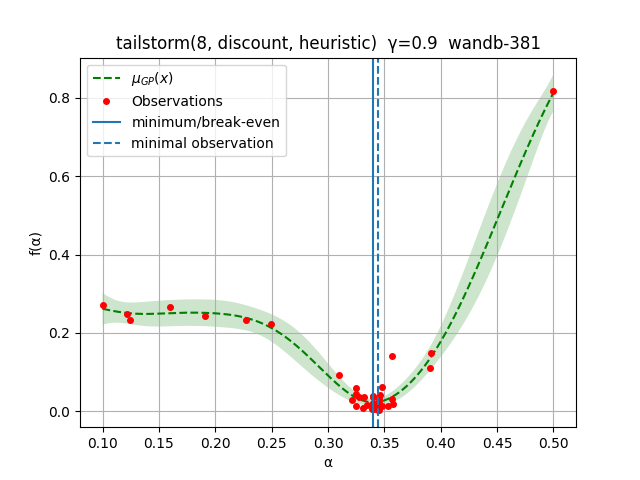

In [20]:
import IPython.display

_ = be_points.break_even_png.apply(
    lambda x: display(IPython.display.Image(data=x, format="png"))
)